In [1]:
# general dependencies
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress

In [2]:
from platform import python_version
python_version()

'3.7.5'

In [3]:
import pycwt as wavelet
from pycwt.helpers import find

In [4]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.scripts import argParser
from LCBDtools.src import Plots

In [7]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

# set block durations
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [8]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [9]:
# make a list of all matching session paths
session_dirs = [d for d in glob(study_dir+"/*/V0/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [10]:
session_dirs

['/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51241/V0/5124_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51241/V0/51241_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51331/V0/51331_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51331/V0/5133_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51491/V0/51491_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/51491/V0/5149_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50841/V0/5084_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50841/V0/50841_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50021/V0/5002_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50021/V0/50021_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50322/V0/50321_V0_fNIRS',
 '/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2/50322/V0/5032_V0_fNIRS',
 '/data/perlman/moochi

In [11]:
# make a list where all of the scans will get loaded into
scans = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        
        # get subject and visit from this path
        sub = os.path.basename(os.path.dirname(dyad_dir))
        visit = os.path.basename(dyad_dir)

        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*fNIRS", "*config*"))

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
                    
        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue

#         # load each in via hypyp loader
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        
    except:
        print("skipping session:", dyad_dir)
        continue

/tmp/ipykernel_63734/1095399143.py:37: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child


There should be 2 evt files. Skipping: 50301_V0_fNIRS


/tmp/ipykernel_63734/1095399143.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_63734/1095399143.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


There should be 2 evt files. Skipping: 50751_V0_fNIRS


/tmp/ipykernel_63734/1095399143.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_63734/1095399143.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_63734/1095399143.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_63734/1095399143.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_63734/1095399143.py:37: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the 

There should be 2 evt files. Skipping: 51161_V0_fNIRS


In [12]:
X = scans[0][0].get_data()

In [13]:
t = scans[0][0].times

In [14]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

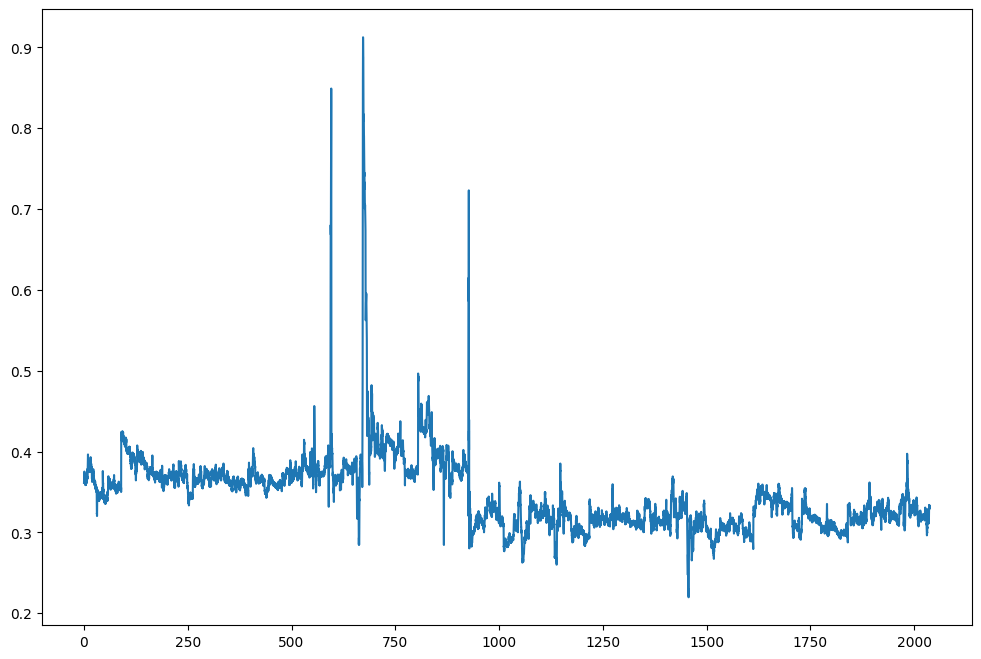

In [15]:
plt.plot(
    t,
    X[10]
)

In [16]:
scans[0][0].info['subject_info']

{'his_id': '50981c',
 'first_name': '50981',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2022, 4, 7)}

In [17]:
scans[0][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [18]:
# rename events and set durations for block 1 and 2

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any stop annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [19]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [20]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? 
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
    
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [21]:
scans[10][1].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

Using matplotlib as 2D backend.


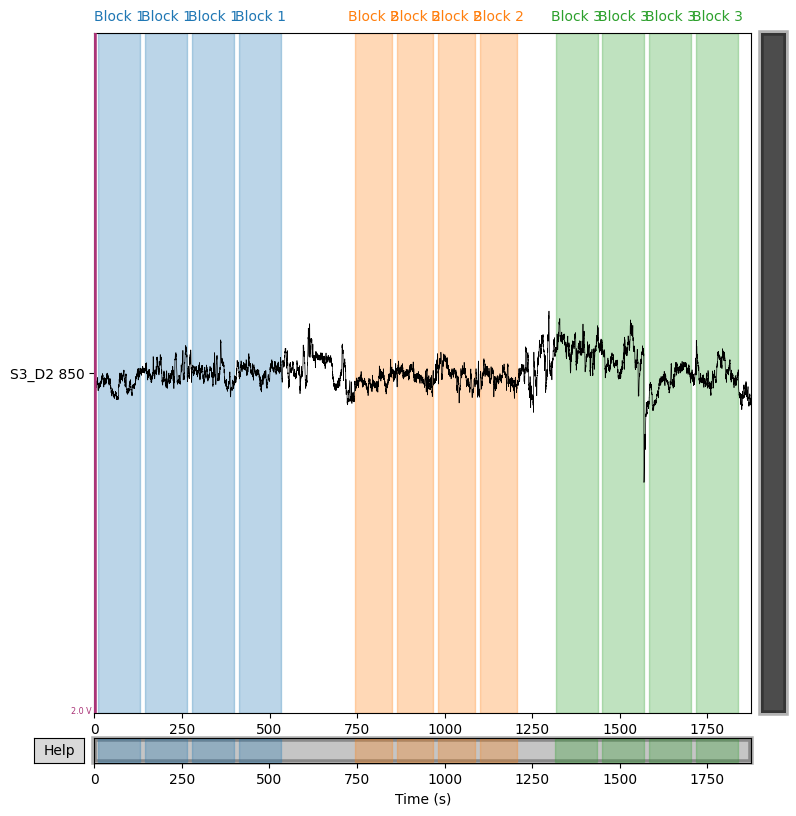

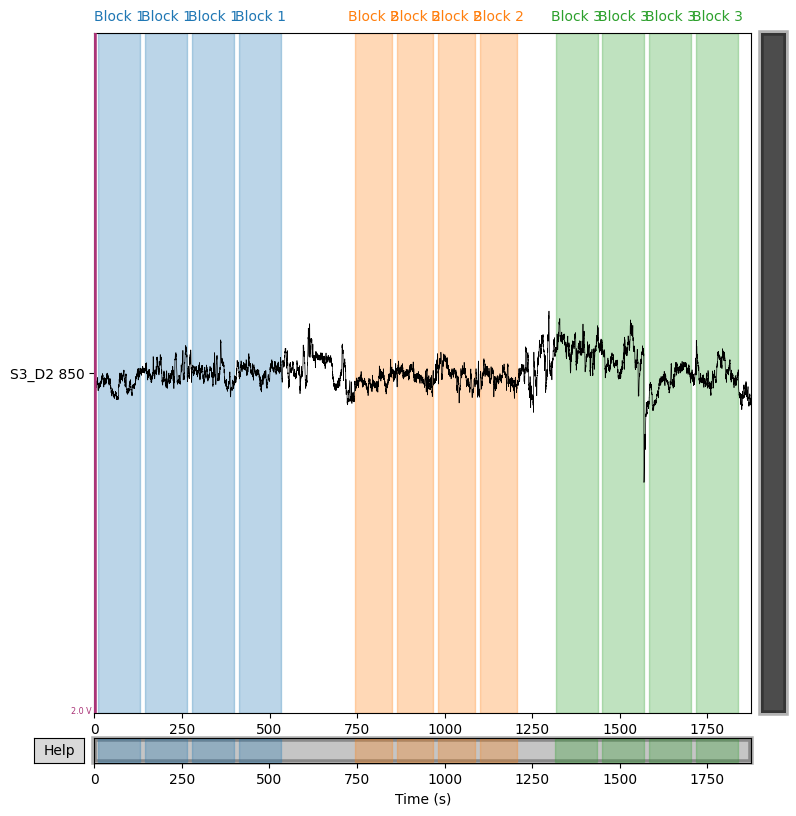

In [22]:
# example plot for 2200 seconds
scans[10][1].copy().pick(['S3_D2 850']).plot(duration=2200, scalings=1)

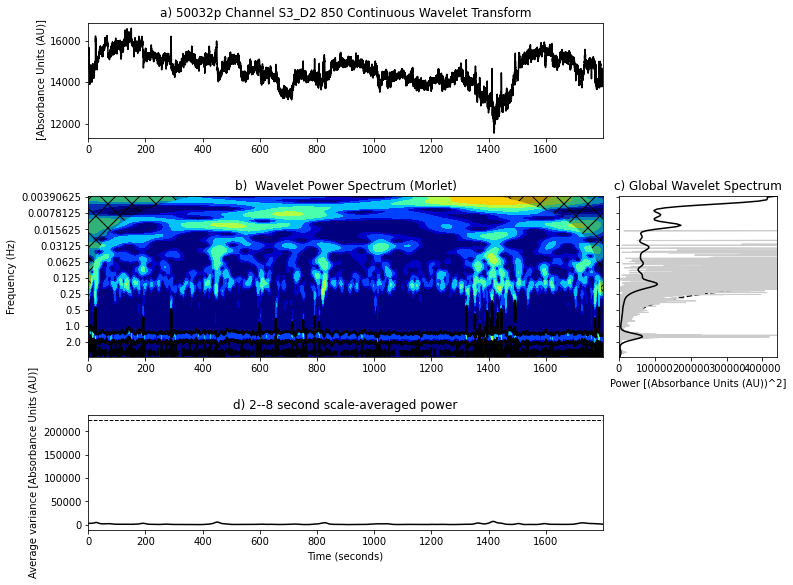

In [23]:
# example wavelet transform for 1900 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[3][1].copy().crop(tmax=1800),
    plot=True,
    chs=['S3_D2 850']
)

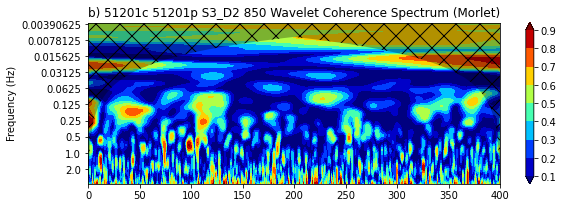

In [24]:
# example coherence transformo from a real dyad with 400 seconds

WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=400),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=400),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [25]:
# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 51382c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51382p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51091c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 50032p : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51281c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51281p : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850']
Bad channels in subject 50321c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50081c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50342p : ['S1_D1 760', 'S1_D1 850', 'S7_D3 760', 'S7_D3 850']
Bad channels in subject 50221p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51251c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51422c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Bad channels in subject 51422p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760',

/tmp/ipykernel_63734/1744041542.py:13: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)
/tmp/ipykernel_63734/1744041542.py:13: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 50701p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51421c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 51421p : ['S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51001c : ['S2_D2 760', 'S2_D2 850']
Bad channels in subject 50381p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 50861p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50771p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 50971c : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50971p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 50491p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']


/tmp/ipykernel_63734/1744041542.py:13: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 51391c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 50111p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S3_D2 760', 'S3_D2 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50721p : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850']
Bad channels in subject 50591p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51411p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51081p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50121c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50711p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51041c : ['S1_D1 760', 'S1_D1 850', 'S3_D2 760', 'S3_D2 850']
Bad channels in subject 51441c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51301c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51301p : ['S6_D3 760', 'S6_D3 850']
Bad channels in subj

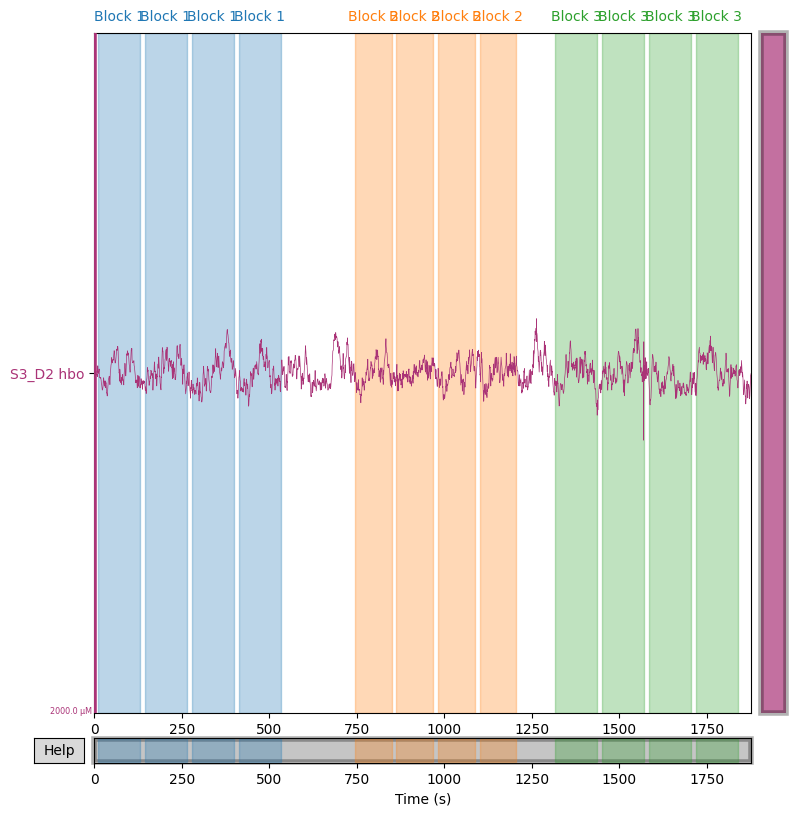

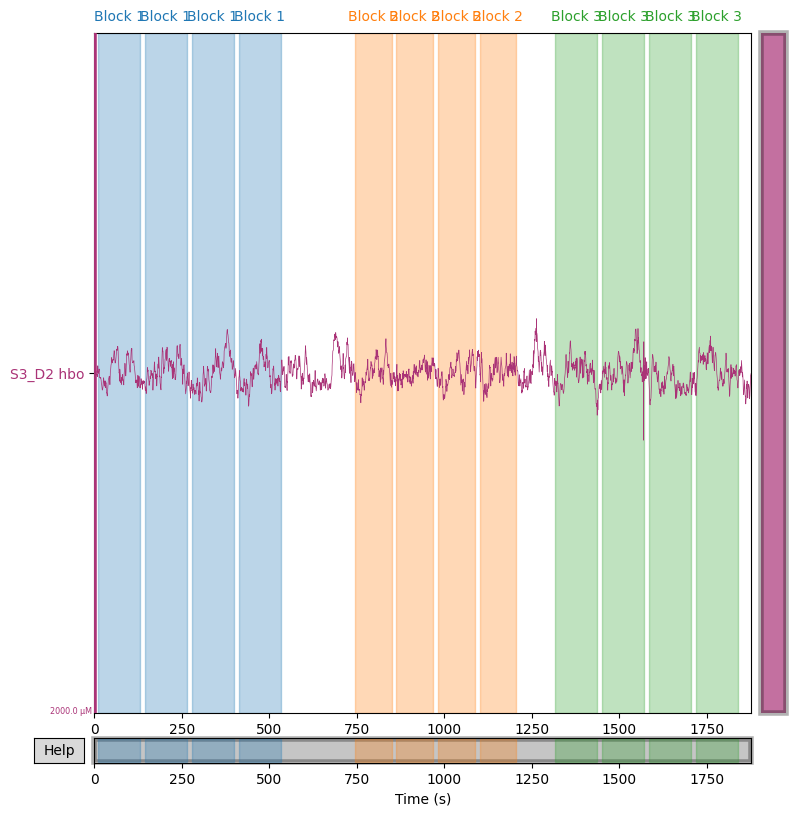

In [26]:
# example plot for 2200 seconds
pps[10][1].copy().pick(['S3_D2 hbo']).plot(duration=2000, scalings=0.001)

In [27]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [28]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#         for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline=(None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

In [29]:
# here is the way to access information in the epoch dictionary

In [30]:
# a single subject 
epoch_df['50531c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [31]:
# a specific channel from the subject
epoch_df['50531c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [32]:
# a specific block at that subject / channel, in this case the first (0) is pre-play
epoch_df['50531c']['S1_D1 hbo'][0]

Number of events,4
Events,Block 1: 4
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [33]:
# a specific iteration of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
epoch_df['50531c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [34]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

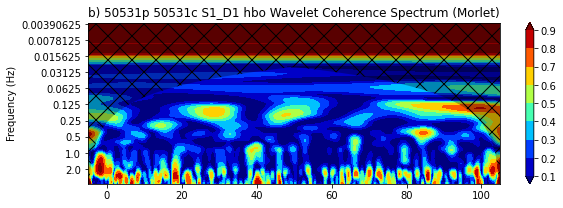

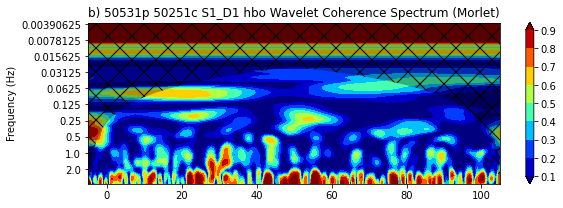

In [35]:
# example WCT between a real dyad, puzzle block (1), iteration 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50531c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50251c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

In [36]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['50981c', '50981p', '51382c', '51382p', '51091c', '51091p', '50032c', '50032p', '51201c', '51201p', '50832c', '50832p', '51281c', '51281p', '50321c', '50321p', '50081c', '50081p', '50342c', '50342p', '50221c', '50221p', '50361c', '50361p', '50991c', '50991p', '51251c', '51251p', '50592c', '50592p', '51422c', '51422p', '50211c', '50211p', '50521c', '50521p', '51341c', '51341p', '50331c', '50331p', '50731c', '50731p', '50961c', '50961p', '50001c', '50001p', '50871c', '50871p', '50801c', '50801p', '51361c', '51361p', '50992c', '50992p', '50891c', '50891p', '50602c', '50602p', '51011c', '51011p', '51381c', '51381p', '51241c', '51241p', '50691c', '50691p', '50071c', '50071p', '50802c', '50802p', '50531c', '50531p', '51141c', '51141p', '51132c', '51132p', '50942c', '50942p', '50962c', '50962p', '50761c', '50761p', '50631c', '50631p', '50551c', '50551p', '50421c', '50421p', '50481c', '50481p', '51082c', '51082p', '51501c', '51501p', '51191c', '51191p', '50841c', '50841p', '50371c',

In [37]:
# delete things we don't need anymore to save memory
del scans
del pps

In [38]:
import random

In [39]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']

# THIS TAKES A REALLY LONG TIME TO COMPUTE. PROBABLY 4 HOURS OR MORE.
# SKIP DOWN TO USE THE SAVED VERSIONS!

# for every parent subject
for parent in [sub for sub in sorted(epoch_df.keys()) if "p" in sub]:
    sync_df[parent] = {}
    
    # pick two children, one real and one random
    children = [parent.replace("p", "c")] # real child
    children.append(
        random.choice([sub for sub in epoch_df.keys() if "c" in sub \
            and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, 1 false)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():
                
                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations
                
                # so start keeping track of average now
                pc_wcts = []
                
                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()
                
                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):
                    
                    # try to do the WCT with these epochs
                    try:
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/CARE/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest
                        # periods == 2s to 20s
                        
                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED right here baby
                        WCT[(2>(1/freqs))|((1/freqs)>20), :] = np.nan

                        # average inside cone of influence
                        # of values from freq range [0.5, ]
                        pc_wcts.append(np.nanmean(nanWCT))
    #                     print(np.nanmean(nanWCT))
    
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                sync_df[parent][child][block][ch] = np.average(pc_wcts)

Warning: Cannot place an upperbound on the unbiased AR(1). Series is too short or trend is to large.

In [ ]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING

In [ ]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/CARE/wct_small_2.json", 'w') as outfile:
    json.dump(sync_df, outfile)

In [ ]:
# LOAD SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/CARE/wct_small_2.json", 'r') as infile:
    sync_df = json.load(infile)

In [77]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

129

In [78]:
# how many parents are in there, without repeats
len(set([sub[:-2] for sub in list(sync_df.keys())]))

107

In [79]:
dyad_b1 = [] # make a list for real dyads
nyad_b1 = [] # make a list for not-real dyads

# this is just using Block 2, i.e. Puzzle

for parent in sync_df.keys():
    # average sync values over all channels for some block
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[0]]['Block 2'].keys()): # for first child (real)
        dyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[0]]['Block 2'][ch])
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[1]]['Block 2'].keys()): # for second child (not real)
        nyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[1]]['Block 2'][ch])

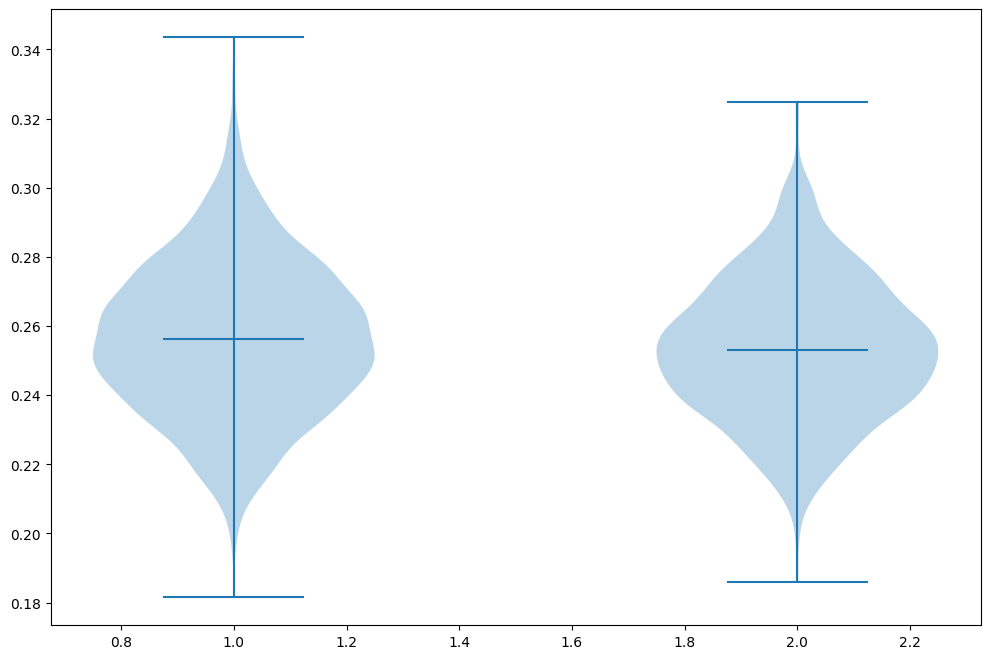

In [80]:
plt.clf()
plt.violinplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

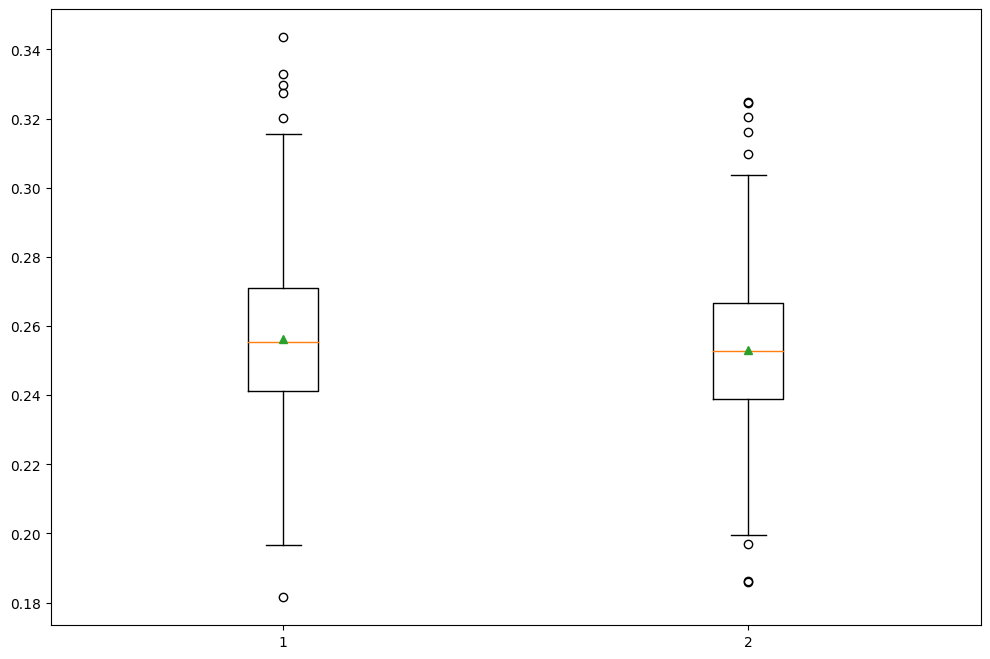

In [81]:
plt.boxplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [82]:
from scipy.stats import ttest_ind

In [83]:
statistic, pvalue = ttest_ind(
    dyad_b1,
    nyad_b1)

In [84]:
statistic

3.7314706124148995

In [86]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.00019447633991549087


In [87]:
# load CSV from emily Hone groups
groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
groups.set_index('subject', inplace=True)

In [88]:
groups

,famid,record_id,rdas_group,enroll_group
subject,,,,
50001,5000,5000-1,Conflict,Divorce
50021,5002,5002-1,Non-Conflict,Control
50031,5003,5003-1,Non-Conflict,Control
50032,5003,5003-2,Non-Conflict,Control
50071,5007,5007-1,Non-Conflict,Control
...,...,...,...,...
51511,5151,5151-1,Conflict,Divorce
51521,5152,5152-1,Non-Conflict,Control
51531,5153,5153-1,Conflict,Divorce


In [89]:
# load CSV from emily Hone's RDAS scores
scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/forkhalil_fullscored.csv")
scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
scores.set_index('subject', inplace=True)
scores.drop(columns=['record_id'], inplace=True)
scores = scores.astype({'famid': 'str'})

In [91]:
scores

,famid,subid,consensus,satisfaction,cohesion,total
subject,,,,,,
50021,5002,1,27,17,13,57
50091,5009,1,29,20,15,64
50092,5009,2,29,20,15,64
50111,5011,1,25,18,11,54
50181,5018,1,29,17,15,61
...,...,...,...,...,...,...
51431,5143,1,18,9,15,42
51441,5144,1,11,3,4,18
51471,5147,1,20,14,11,45


In [94]:
scores.columns

Index(['famid', 'subid', 'consensus', 'satisfaction', 'cohesion', 'total'], dtype='object')

In [96]:
# see how many rows there are in there
# weird number, huh?
# it's because not everybody has RDAS data :(
len([id for id in scores.index])

112

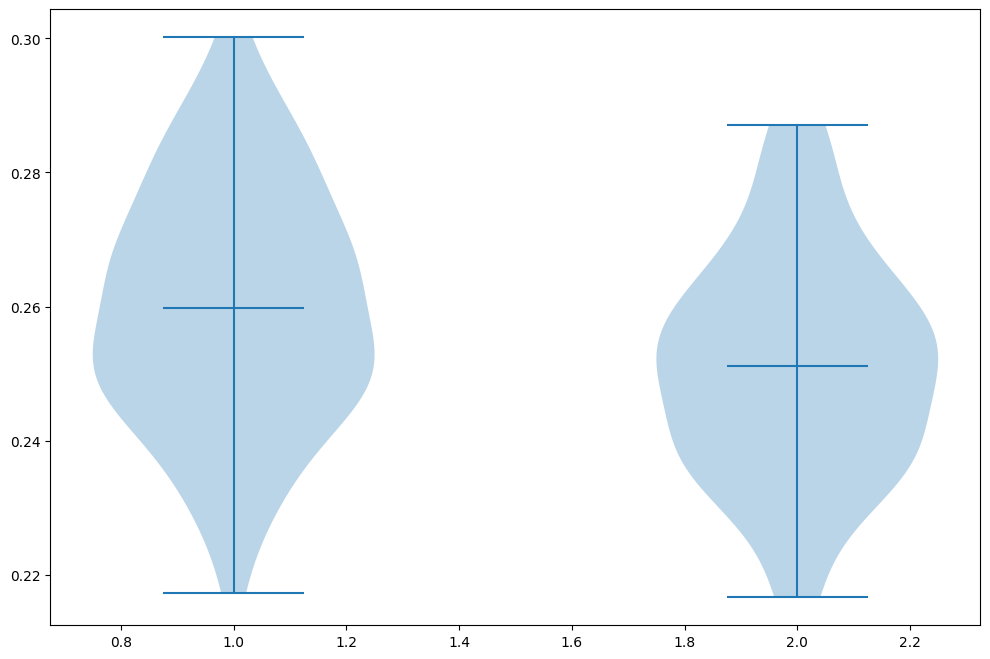

T stat: 2.7066014063581245 
 P value: 0.007732759681705392


In [97]:
group1syncs = [] # get synchrony from all of groups 1 (control)
group2syncs = [] # get synchrony from problem group

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [98]:
np.std(group2syncs)

0.016444974052242916

In [99]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [100]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [101]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

In [102]:
list(sync_df.keys())[0]

'50001p'

In [103]:
# for block_num in blocks.keys():
#     block_name = blocks[block_num]

#     syncs = [np.average([
#     #     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
#         sync_df[parent][parent.replace('p', 'c')][block_num][ch] \
#             for ch in channels]) for parent in sync_df.keys() \
#                 if parent.replace('p', '')[:-1] in list(scores['famid'])]
    
#     for COI in COIs:
        
# #         rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
# #             if sub.replace('p', '')[:-1] in list(scores['fam_id'])]]
        
#         rdas = []
#         for sub in sync_df.keys():
#             if sub.replace('p', '')[:-1] in list(scores['famid']):
#                 rdas.append(
#                     scores[scores['famid'] == sub.replace('p', '')[:-1]][COI][0])
#             else:
# #                 rdas.append(np.nan)
#                 print("No RDAS data for:", sub)
#                 print("Group:", groups[sub.replace('p', '')])

#         xnan = np.array(rdas, dtype='float')
#         ynan = np.array(syncs, dtype='float')
        
# #         # get IQR
# #         q75, q25 = np.percentile(xnan, [75, 25])
# #         intr_qr = q75 - q25
# #         qmax = q75 + (1.5 * intr_qr)
# #         qmin = q25 - (1.5 * intr_qr)
        
# #         # remove the extra-IQR vals
# #         xnan[xnan < qmin] = qmin
# #         xnan[xnan > qmax] = qmin


    
#         x = np.delete(xnan, np.where(np.isnan(xnan)))
#         y = np.delete(ynan, np.where(np.isnan(xnan)))
        
#         print("x shape:", x.shape)
#         print("y shape:", y.shape)
        
#         # winsorize(y, inplace=True, limits=[0.05, 0.05])
#         # winsorize(x, inplace=True, limits=[0.05, 0.05])
        
#         X = x
#         Y = y
        
#         x = x.reshape(-1, 1)

#         model = LinearRegression().fit(x, y)
        
#         r_sq = model.score(x, y)
#         print(f"Coefficient of Determination: {r_sq}")
#         print(f"intercept: {model.intercept_}")
#         print(f"slope: {model.coef_}")
        
#         plt.clf()
#         # plot data
#         plt.scatter(
#             x,
#             y,
#             color='black')
#         # plot regression line
#         plt.plot(
#             np.linspace(np.min(x), np.max(x)),
#             model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
#             color='blue',
#             linewidth=3)
#         plt.xlabel(f"RDAS {COI.upper()}")
#         plt.ylabel(f"Dyadic Synchrony in {block_name}")
#         plt.title(f"{block_name}: {COI}")

#         plt.show()
# #         plt.savefig(
# #             f"/data/perlman/moochie/analysis/CARE/{block_name}_RDAS_{COI}.png",
# #             dpi=100)

#         X2 = sm.add_constant(X)
#         est = sm.OLS(Y, X2)
#         est2 = est.fit()
#         print(est2.summary())

Coefficient of Determination: 0.045943867613540634
intercept: 0.24335276267275804
slope: [0.00060838]


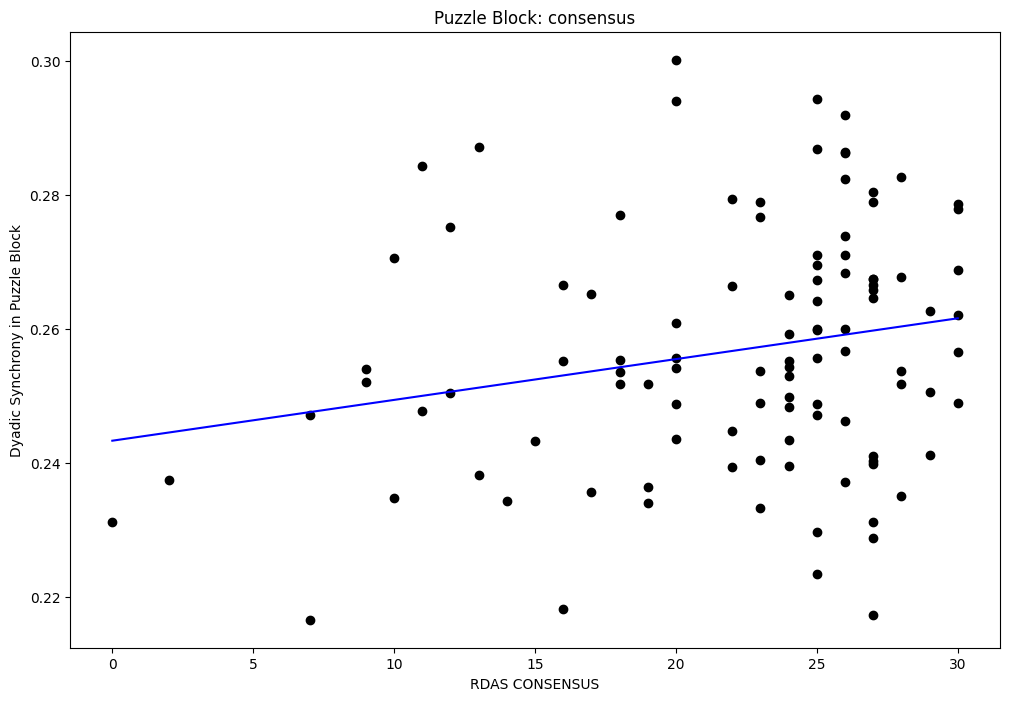

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.960
Date:                Fri, 11 Nov 2022   Prob (F-statistic):             0.0281
Time:                        16:39:54   Log-Likelihood:                 274.06
No. Observations:                 105   AIC:                            -544.1
Df Residuals:                     103   BIC:                            -538.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2434      0.006     38.765      0.0

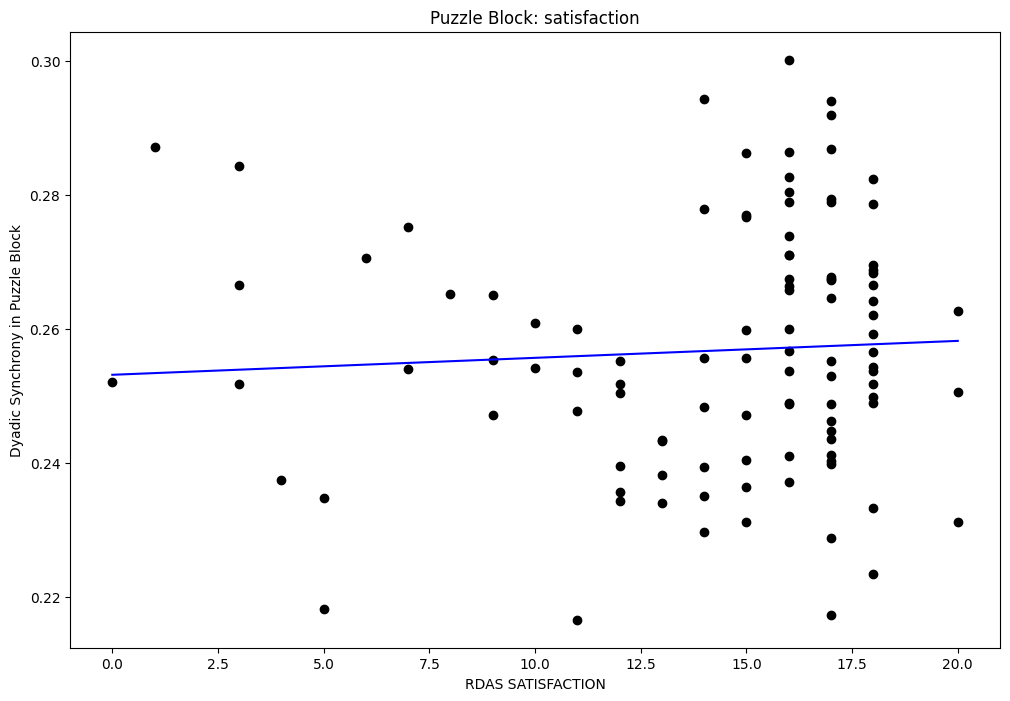

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3781
Date:                Fri, 11 Nov 2022   Prob (F-statistic):              0.540
Time:                        16:39:54   Log-Likelihood:                 271.78
No. Observations:                 105   AIC:                            -539.6
Df Residuals:                     103   BIC:                            -534.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2532      0.006     41.390      0.0

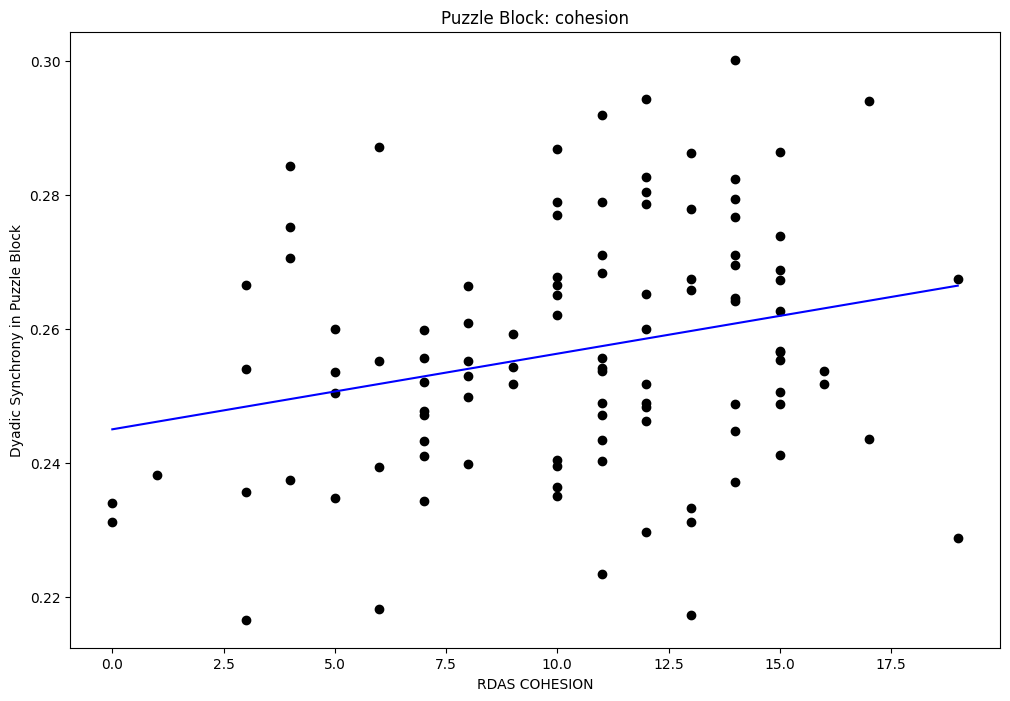

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     7.109
Date:                Fri, 11 Nov 2022   Prob (F-statistic):            0.00891
Time:                        16:39:54   Log-Likelihood:                 275.09
No. Observations:                 105   AIC:                            -546.2
Df Residuals:                     103   BIC:                            -540.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2451      0.005     51.826      0.0

In [104]:
# syncs = [
#     sync_df[parent][parent.replace('p', 'c')]['Block 3']['S7_D3 hbo'] - sync_df[parent][parent.replace('p', 'c')]['Block 1']['S7_D3 hbo'] \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]
channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

# block_num = 'Block 1'
block_name = 'Puzzle Block'

# syncs = [np.average([
#     list(sync_df[parent][parent.replace('p', 'c')][block_num][ch]) for ch in frontal_channels]) \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]

syncs = [np.average([
#     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
    sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] \
        for ch in channels]) for parent in sync_df.keys() \
            if parent.replace('p', '') in list(scores.index)]

for COI in COIs:

    rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
        if sub.replace('p', '') in list(scores.index)]]

    xnan = np.array(rdas, dtype='float')
    ynan = np.array(syncs, dtype='float')

#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)

#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))

    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    X = x
    Y = y

    x = x.reshape(-1, 1)

    model = LinearRegression().fit(x, y)

    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    plt.clf()
    # plot data
    plt.scatter(
        x,
        y,
        color='black')
    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)
    plt.xlabel(f"RDAS {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")

    plt.show()

    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())